In [21]:
import os 
from topofm.data import download_single_cell_data
import scanpy as sc
import numpy as np
from anndata import AnnData


# If the file doesn't exist, download the data
if not os.path.exists("./ebdata_v3.h5ad"):
    download_single_cell_data(data_dir='./')

adata = sc.read_h5ad("./ebdata_v3.h5ad")

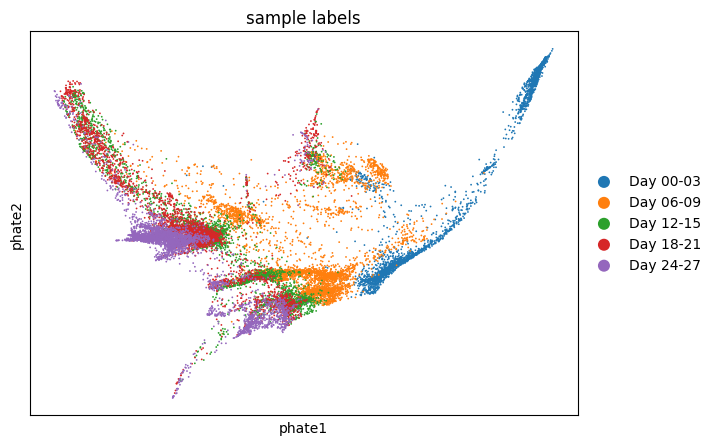

In [22]:
sc.pl.scatter(adata, basis="phate", color="sample_labels")

In [31]:
# Standardize coordinates
coords = adata.obsm["X_phate"]
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
labels = adata.obs["sample_labels"].cat.codes.to_numpy()
adata.obsm["X_phate_standardized"] = coords

In [32]:
times = np.sort(np.unique(adata.obs["sample_labels"].cat.codes.to_numpy()))
x_true = [
    adata.obsm["X_phate_standardized"][labels == t]
    for t in times
]
mu_true = [
    (labels == t) / np.sum(labels == t)
    for t in times
]

In [36]:
np.save("coord.npy", coords)
np.save("label.npy", labels)

for t, mu in enumerate(mu_true):
    np.save(f"mu{t}.npy", mu[None, :].copy())

In [47]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

# Use standardized PHATE coordinates
k = 250  # You can adjust k as needed
adjacency = kneighbors_graph(coords, n_neighbors=k, mode='connectivity', include_self=False)
A = adjacency.maximum(adjacency.T).tocsr()   # symmetrize (keeps it sparse)


# 2) How many nontrivial eigenpairs you want
k = 128
L = csgraph.laplacian(A, normed=False).tocsr()

# 4) Smallest eigenpairs via ARPACK (Lanczos)
#    If this stalls, see the shift-invert fallback below.
vals, vecs = eigsh(L, k=k, which='SA', tol=1e-6, maxiter=2000)


In [48]:
# Save adjacency matrix
np.save("A.npy", A)

# Save eigenvectors and eigenvalues of the Laplacian
np.save("L_eigenvectors.npy", vecs)
np.save("L_eigenvalues.npy", vals)

# Convert predictions on graph into time predictions

In [10]:
import torch 
import matplotlib.pyplot as plt
from topofm.data import load_single_cell_data
import pandas as pd
import scanpy as sc
from topofm.utils import single_cell_to_times


def as_ndarray(x) -> np.ndarray:
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    else:
        return np.asarray(x)


def _plot_single_cell_data(
    sample_labels: pd.Categorical,
    X_phate: np.ndarray,
    *, 
    ax: plt.Axes | None = None,
    show_legend: bool = False,
    title: str | None = None,
) -> None:
    adata = AnnData(X=X_phate)
    adata.obsm["X_phate"] = X_phate
    adata.obs["sample_labels"] = sample_labels
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    else:
        fig = ax.get_figure()

    sc.pl.scatter(
        adata,
        basis="phate",
        color="sample_labels",
        ax=ax,
        show=False,
        title=title, 
        legend_loc="none" if not show_legend else "right margin",
    )
    
    return fig, ax


def plot_single_cell_predictions(
    x1_pred: torch.Tensor,
    *, 
    data_dir: str = './', 
) -> None:
    adata = sc.read_h5ad(os.path.join(data_dir, "ebdata_v3.h5ad"))
    X_phate = adata.obsm["X_phate"]
    sample_labels = adata.obs["sample_labels"].values
    
    # Create the predictions dataset
    times_pred = single_cell_to_times(
        x1_pred, 
        torch.as_tensor(adata.obs["sample_labels"].cat.codes.values),
    )
    sample_labels_pred = pd.Categorical.from_codes(
        times_pred, 
        categories=adata.obs['sample_labels'].cat.categories,
    )

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    _plot_single_cell_data(
        sample_labels=sample_labels_pred,
        X_phate=X_phate,
        ax=axs[0],
        title="Predicted",
    )
    _plot_single_cell_data(
        sample_labels=sample_labels,
        X_phate=X_phate,
        ax=axs[1],
        show_legend=True,
        title="True",
    )
    return fig, axs


In [11]:
times = np.load("label.npy").astype(np.int8)
phate = np.load("coord.npy")


/tmp/ipykernel_349336/3351133831.py:58: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch.as_tensor(adata.obs["sample_labels"].cat.codes.values),


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Predicted'}, xlabel='phate1', ylabel='phate2'>,
        <Axes: title={'center': 'True'}, xlabel='phate1', ylabel='phate2'>],
       dtype=object))

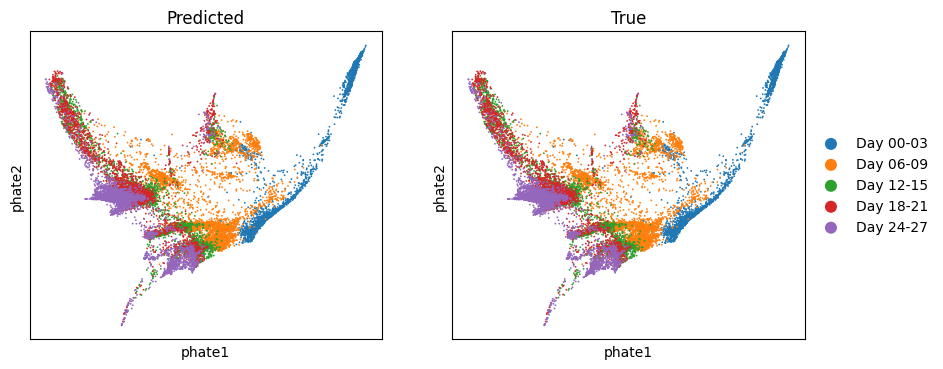

In [12]:
plot_single_cell_predictions(
    x1_pred=torch.as_tensor(times), 
    data_dir="./",
)